Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


61/61 ━━━━━━━━━━━━━━━━━━━━ 13s 198ms/step - accuracy: 0.3119 - loss: 1.5535 - val_accuracy: 0.6947 - val_loss: 1.0735
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 12s 196ms/step - accuracy: 0.7196 - loss: 0.8937 - val_accuracy: 0.8316 - val_loss: 0.5556
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 12s 197ms/step - accuracy: 0.8596 - loss: 0.4705 - val_accuracy: 0.8819 - val_loss: 0.4218
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 12s 200ms/step - accuracy: 0.8958 - loss: 0.3399 - val_accuracy: 0.8854 - val_loss: 0.3783
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 12s 197ms/step - accuracy: 0.9197 - loss: 0.2700 - val_accuracy: 0.9041 - val_loss: 0.3347
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 12s 200ms/step - accuracy: 0.9366 - loss: 0.2140 - val_accuracy: 0.8947 - val_loss: 0.3487
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 12s 200ms/step - accuracy: 0.9377 - loss: 0.2098 - val_accuracy: 0.9018 - val_loss: 0.3195
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 12s 203ms/step - accuracy: 0.9401 - loss: 0.1933 - val_accuracy: 0.907

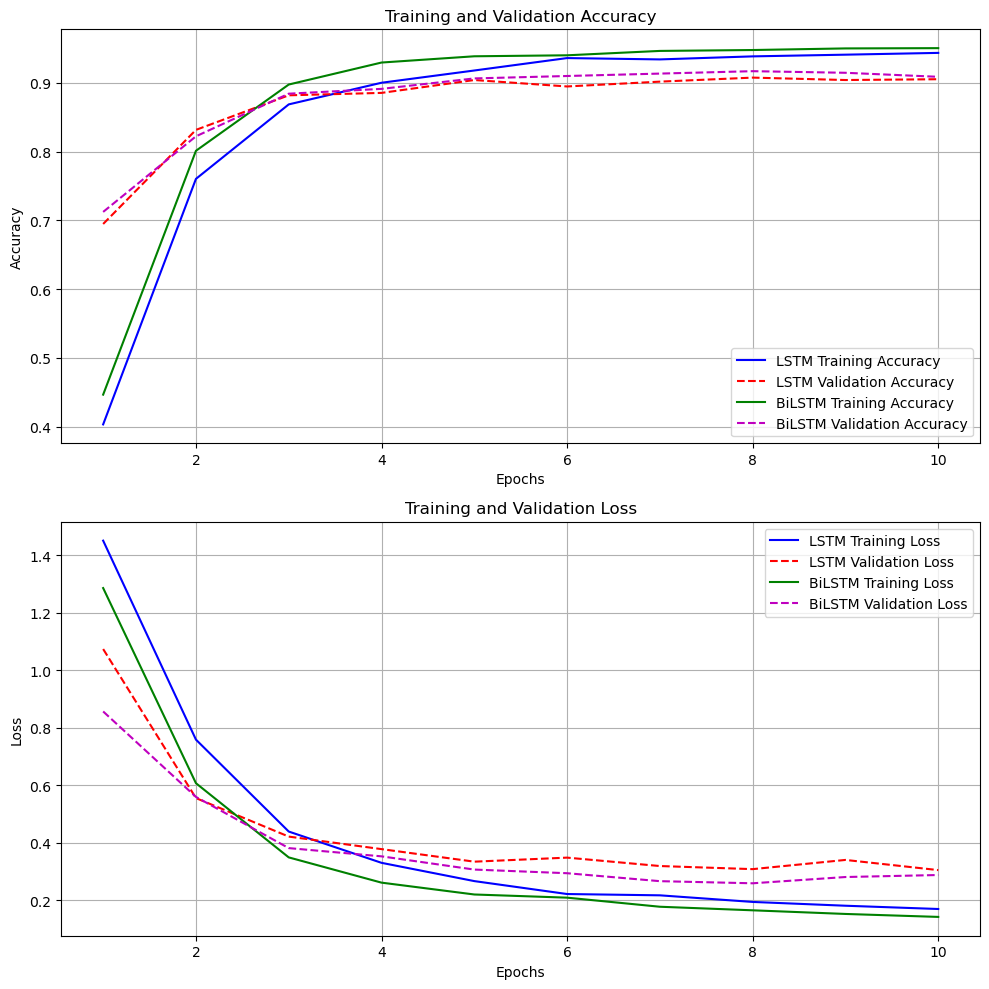

Figure saved as 'training_validation_accuracy_loss.png' with 300 DPI.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Load and preprocess data
df = pd.read_csv('Sarcasm_multiclassification.csv', encoding='latin1')

# Text cleaning function
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    stop_words = set(stopwords.words('english'))
    tokens = text.split()
    filtered_tokens = [token for token in tokens if token not in stop_words]
    lemmatized_tokens = [WordNetLemmatizer().lemmatize(token) for token in filtered_tokens]
    return ' '.join(lemmatized_tokens)

df['comment_Text'] = df['comment_Text'].apply(clean_text)
df.dropna(subset=['comment_Text', 'Sarcasm_Type'], inplace=True)

# Label encoding
y_dict = {'Humor': 0, 'Flattery': 1, 'Self-Deprecation': 2, 'Irony': 3, 'Passive-Aggression': 4}
df['Sarcasm_Type_Encoded'] = df['Sarcasm_Type'].map(y_dict)

# Prepare the data
X = df['comment_Text'].values
y = [y_dict[item] for item in df['Sarcasm_Type'].values]
y = to_categorical(y, num_classes=len(y_dict))

# Tokenization and padding
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X)
X = pad_sequences(tokenizer.texts_to_sequences(X), maxlen=150)

# Oversampling
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X, y)

# Define and compile LSTM and BiLSTM models
lstm_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(5000, 128, input_length=150),
    tf.keras.layers.LSTM(128, dropout=0.5, recurrent_dropout=0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(y_dict), activation='softmax')
])
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

bilstm_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(5000, 128, input_length=150),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, dropout=0.2, recurrent_dropout=0.2)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(y_dict), activation='softmax')
])
bilstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# K-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
all_lstm_histories = []
all_bilstm_histories = []

for train_index, test_index in kf.split(X_resampled):
    X_train, X_test = X_resampled[train_index], X_resampled[test_index]
    y_train, y_test = y_resampled[train_index], y_resampled[test_index]
    
    # Train LSTM and BiLSTM models
    lstm_history = lstm_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=128)
    all_lstm_histories.append(lstm_history.history)
    
    bilstm_history = bilstm_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=128)
    all_bilstm_histories.append(bilstm_history.history)

# Plotting accuracy and loss for LSTM and BiLSTM
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Accuracy subplot
axs[0].plot(range(1, 11), all_lstm_histories[0]['accuracy'], 'b-', label='LSTM Training Accuracy')
axs[0].plot(range(1, 11), all_lstm_histories[0]['val_accuracy'], 'r--', label='LSTM Validation Accuracy')
axs[0].plot(range(1, 11), all_bilstm_histories[0]['accuracy'], 'g-', label='BiLSTM Training Accuracy')
axs[0].plot(range(1, 11), all_bilstm_histories[0]['val_accuracy'], 'm--', label='BiLSTM Validation Accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend()
axs[0].grid(True)

# Loss subplot
axs[1].plot(range(1, 11), all_lstm_histories[0]['loss'], 'b-', label='LSTM Training Loss')
axs[1].plot(range(1, 11), all_lstm_histories[0]['val_loss'], 'r--', label='LSTM Validation Loss')
axs[1].plot(range(1, 11), all_bilstm_histories[0]['loss'], 'g-', label='BiLSTM Training Loss')
axs[1].plot(range(1, 11), all_bilstm_histories[0]['val_loss'], 'm--', label='BiLSTM Validation Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].grid(True)

# Save the combined figure
plt.tight_layout()
fig.savefig('training_validation_accuracy_loss.png', dpi=300)
plt.show()

print("Figure saved as 'training_validation_accuracy_loss.png' with 300 DPI.")


In [2]:
# Accuracy subplot
axs[0].plot(range(1, 11), all_lstm_histories[0]['accuracy'], 'b-', label='LSTM Training Accuracy')
axs[0].plot(range(1, 11), all_lstm_histories[0]['val_accuracy'], 'r--', label='LSTM Validation Accuracy')
axs[0].plot(range(1, 11), all_bilstm_histories[0]['accuracy'], 'g-', label='BiLSTM Training Accuracy')
axs[0].plot(range(1, 11), all_bilstm_histories[0]['val_accuracy'], 'm--', label='BiLSTM Validation Accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend()
axs[0].grid(True)

# Loss subplot
axs[1].plot(range(1, 11), all_lstm_histories[0]['loss'], 'b-', label='LSTM Training Loss')
axs[1].plot(range(1, 11), all_lstm_histories[0]['val_loss'], 'r--', label='LSTM Validation Loss')
axs[1].plot(range(1, 11), all_bilstm_histories[0]['loss'], 'g-', label='BiLSTM Training Loss')
axs[1].plot(range(1, 11), all_bilstm_histories[0]['val_loss'], 'm--', label='BiLSTM Validation Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].grid(True)

# Save the combined figure
plt.tight_layout()
fig.savefig('training_validation_accuracy_loss.png', dpi=300)
plt.show()

print("Figure saved as 'training_validation_accuracy_loss.png' with 300 DPI.")

<Figure size 640x480 with 0 Axes>

Figure saved as 'training_validation_accuracy_loss.png' with 300 DPI.
